<a href="https://colab.research.google.com/github/MosheWasserb/PyTorchNotbooks/blob/master/MultiClassBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Visual Notebook to Using BERT for the First TIme.ipynb



<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-sentence-classification.png" />

In this notebook, we will use pre-trained deep learning model to process some text. We will then use the output of that model to classify the text. The text is a list of sentences from film reviews. And we will calssify each sentence as either speaking "positively" about its subject of "negatively".

## Models: Sentence Sentiment Classification
Our goal is to create a model that takes a sentence (just like the ones in our dataset) and produces either 1 (indicating the sentence carries a positive sentiment) or a 0 (indicating the sentence carries a negative sentiment). We can think of it as looking like this:

<img src="https://jalammar.github.io/images/distilBERT/sentiment-classifier-1.png" />

Under the hood, the model is actually made up of two model.

* DistilBERT processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either positive or negative (1 or 0, respectively).

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.


<img src="https://jalammar.github.io/images/distilBERT/distilbert-bert-sentiment-classifier.png" />

## Dataset
The dataset we will use in this example is [SST2](https://nlp.stanford.edu/sentiment/index.html), which contains sentences from movie reviews, each labeled as either positive (has the value 1) or negative (has the value 0):


<table class="features-table">
  <tr>
    <th class="mdc-text-light-green-600">
    sentence
    </th>
    <th class="mdc-text-purple-600">
    label
    </th>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      apparently reassembled from the cutting room floor of any given daytime soap
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      they presume their audience won't sit still for a sociology lesson
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      this is a visually stunning rumination on love , memory , history and the war between art and commerce
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      jonathan parker 's bartleby should have been the be all end all of the modern office anomie films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
</table>

## Installing the transformers library
Let's start by installing the huggingface transformers library so we can load our deep learning NLP model.

In [0]:
!pip install transformers

     |████████████████████████████████| 552kB 4.6MB/s 
     |████████████████████████████████| 1.0MB 49.3MB/s 
     |████████████████████████████████| 870kB 50.0MB/s 
     |████████████████████████████████| 3.7MB 29.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=12547da9b309d7088c11086879726da7dfc9adb9e31b5f3f13918f0dfa34e9c4
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
import time
from sklearn import preprocessing
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_


## Importing the dataset
We'll use pandas to read the dataset and load it into a dataframe.

In [0]:
### read data from your Google Drive
from google.colab import drive
drive.mount('/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


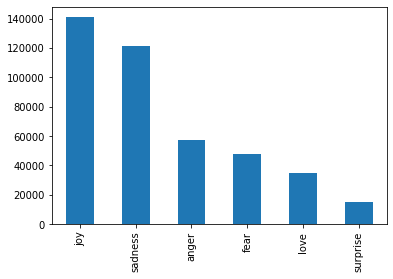

In [0]:
# load data
data = pd.read_csv(r"/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/multiclass6ed.csv")
data.emotions.value_counts().plot.bar()

For performance reasons, we'll only use 2,000 sentences from the dataset

In [0]:
batch_1 = data.sample(n=8000, random_state=42);

We can ask pandas how many sentences are labeled as "positive" (value 1) and how many are labeled "negative" (having the value 0)

In [0]:
batch_1.head(5)

,text,emotions
36130,i just feel really helpless and heavy hearted,fear
138065,ive enjoyed being able to slouch about relax a...,sadness
146440,i gave up my internship with the dmrg and am f...,fear
103337,i dont know i feel so lost,sadness
315528,i am a kindergarten teacher and i am thoroughl...,fear


## Loading the Pre-trained BERT model
Let's now load a pre-trained BERT model. 

In [0]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

## Want Roberta instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'roberta-base')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
BertModel = model_class.from_pretrained(pretrained_weights)

Right now, the variable `model` holds a pretrained distilBERT model -- a version of BERT that is smaller, but much faster and requiring a lot less memory.

## Model #1: Preparing the Dataset
Before we can hand our sentences to BERT, we need to so some minimal processing to put them in the format it requires.

### Tokenization
Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

In [0]:
tokenized = batch_1['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

### Padding
After tokenization, `tokenized` is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [0]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

Our dataset is now in the `padded` variable, we can view its dimensions below:

In [0]:
np.array(padded).shape

(8000, 70)

### Masking
If we directly send `padded` to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [0]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(8000, 70)

Convert to tensors

In [0]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

## Model #1: And Now, Deep Learning!
Now that we have our model and inputs ready, let's run our model!

<img src="http://127.0.0.1:4000/images/distilBERT/bert-distilbert-tutorial-sentence-embedding.png" />

The `model()` function runs our sentences through BERT. The results of the processing will be returned into `last_hidden_states`.

In [0]:
start = time.time()


with torch.no_grad():
    last_hidden_states = BertModel(input_ids, attention_mask=attention_mask)

print('Time taken for convert tokens to BERT vectos in sec {} \n'.format(time.time() - start))

Time taken for convert tokens to BERT vectos in sec 34.50823092460632 



Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called `[CLS]` (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />

We'll save those in the `features` variable, as they'll serve as the features to our logitics regression model.

In [0]:
features = last_hidden_states[0][:,0,:].numpy()

The labels indicating which sentence is positive and negative now go into the `labels` variable

In [0]:
labels = batch_1['emotions']

## Model #2: Train/Test Split
Let's now split our datset into a training set and testing set (even though we're using 2,000 sentences from the SST2 training set).

Splite features and text with the same seed

In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels,test_size=0.2,random_state=42)

In [0]:
test_features

array([[-0.05213079,  0.12589307, -0.01424439, ...,  0.01280174,
         0.39185014,  0.48322433],
       [ 0.1126171 ,  0.04323838, -0.38042873, ..., -0.00996881,
         0.30511034,  0.47356904],
       [ 0.09995174, -0.00733955,  0.13381942, ..., -0.02475775,
         0.24149266,  0.1853386 ],
       ...,
       [ 0.06656996,  0.02826398,  0.1483224 , ..., -0.01892123,
         0.48214912,  0.3743777 ],
       [-0.02894961, -0.03782853, -0.19266544, ..., -0.11153548,
         0.25140786,  0.15073338],
       [ 0.06396559,  0.02125023, -0.04242096, ..., -0.01619827,
         0.25751355,  0.17458858]], dtype=float32)

In [0]:
train_texts, test_texts = train_test_split(batch_1['text'],test_size=0.2,random_state=42)

In [0]:
train_token_tensor, test_token_tensor, train_mask_tensor, test_mask_tensor = train_test_split(input_ids,attention_mask,test_size=0.2,random_state=42)

<img src="http://127.0.0.1:4000/images/distilBERT/bert-distilbert-train-test-split-sentence-embedding.png" />

### [Bonus] Grid Search for Parameters
We can dive into Logistic regression directly with the Scikit Learn default parameters, but sometimes it's worth searching for the best value of the C parameter, which determines regularization strength.

In [0]:
 #parameters = {'C': np.linspace(0.0001, 100, 20)}
 #grid_search = GridSearchCV(LogisticRegression(), parameters)
 #grid_search.fit(train_features, train_labels)

 #print('best parameters: ', grid_search.best_params_)
 #print('best scrores: ', grid_search.best_score_)

best parameters:  {'C': 5.263252631578947}
best scrores:  0.5479999999999999


We now train the LogisticRegression model. If you've chosen to do the gridsearch, you can plug the value of C into the model declaration (e.g. `LogisticRegression(C=5.2)`).

<img src="http://127.0.0.1:4000/images/distilBERT/bert-training-logistic-regression.png" />

## Evaluating Model #2
So how well does our model do in classifying sentences? One way is to check the accuracy against the testing dataset:

In [0]:
lr_clf = LogisticRegression()
lr_baseline_model=lr_clf.fit(train_features, train_labels)
lr_baseline_predicted = lr_baseline_model.predict(test_features)
print(classification_report(test_labels, lr_baseline_predicted))

              precision    recall  f1-score   support

       anger       0.41      0.35      0.38        26
        fear       0.55      0.30      0.39        20
         joy       0.68      0.72      0.70        57
        love       0.20      0.09      0.13        11
     sadness       0.42      0.58      0.49        45
    surprise       0.00      0.00      0.00         1

    accuracy                           0.52       160
   macro avg       0.38      0.34      0.35       160
weighted avg       0.51      0.52      0.50       160



In [0]:
lr_clf.score(test_features, test_labels)

0.51875

How good is this score? What can we compare it against? Let's first look at a dummy classifier:

In [0]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.236 (+/- 0.07)


Comare to simple baseline bi-gram count model

In [0]:
ngramCount_baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)
ngramCount_baseline_predicted = ngramCount_baseline_model.predict(test_texts)
print(classification_report(test_labels, ngramCount_baseline_predicted))

              precision    recall  f1-score   support

       anger       0.33      0.04      0.07        26
        fear       0.50      0.05      0.09        20
         joy       0.49      0.84      0.62        57
        love       0.00      0.00      0.00        11
     sadness       0.48      0.60      0.53        45
    surprise       0.00      0.00      0.00         1

    accuracy                           0.48       160
   macro avg       0.30      0.26      0.22       160
weighted avg       0.43      0.48      0.39       160



So our model clearly does better than a dummy classifier. But how does it compare against the best models?

## Proper SST2 scores
For reference, the [highest accuracy score](http://nlpprogress.com/english/sentiment_analysis.html) for this dataset is currently **96.8**. DistilBERT can be trained to improve its score on this task – a process called **fine-tuning** which updates BERT’s weights to make it achieve a better performance in this sentence classification task (which we can call the downstream task). The fine-tuned DistilBERT turns out to achieve an accuracy score of **90.7**. The full size BERT model achieves **94.9**.



And that’s it! That’s a good first contact with BERT. The next step would be to head over to the documentation and try your hand at [fine-tuning](https://huggingface.co/transformers/examples.html#glue). You can also go back and switch from distilBERT to BERT and see how that works.

**BERT Fine Tune**

### 2.1 Init


In [0]:
BATCH_SIZE=64
EPOCHS =5
HIDDEN_SIZE=768

emotions=list(set(batch_1.emotions.unique()))
OUTPUT_DIM= len(emotions)   #num of catagories

### 2.1 Binarization
We would like to binarize our target so that we can obtain one-hot encodings as target values. These are easier and more efficient to work with and will be useful when training the models.

In [0]:
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in batch_1[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor_bin = torch.tensor(bin_emotions.tolist())

In [0]:
target_tensor=torch.max(target_tensor_bin,1)[1]

### 2.1 Tranform labels to float
We would like to binarize our target so that we can obtain one-hot encodings as target values. These are easier and more efficient to work with and will be useful when training the models.

In [0]:
#target_num_tensor2=torch.tensor(LabelEncoder().fit_transform(batch_1['emotions']))
#target_tensor2 = target_num_tensor2.reshape(-1,1).float()

In [0]:
target_tensor2[0:2]

tensor([[1.],
        [4.]])

In [0]:
from torch.utils.data import Dataset, DataLoader

### 2.2 Convert to tensors


In [0]:
train_tokens_tensor, test_tokens_tensor, train_masks_tensor, test_masks_tensor = train_test_split(input_ids,attention_mask,test_size=0.2,random_state=42)
train_y_tensor, test_y_tensor  = train_test_split(target_tensor,test_size=0.2,random_state=42)

### 2.3 Build DataLoader


In [0]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

### 2.4 Define Model 


In [0]:
class BertMultiClassifier(torch.nn.Module):
    def __init__(self, dropout=0.1):
        super(BertMultiClassifier, self).__init__()
        # Need to define the right layer 
        self.bert = model_class.from_pretrained(pretrained_weights)
        #self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(HIDDEN_SIZE, OUTPUT_DIM)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        last_hidden_states = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = last_hidden_states[0][:,0,:]
        #dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(pooled_output)
        proba = self.sigmoid(linear_output)
        return linear_output

### 2.5 BERT Fine tune Training 


In [0]:
bert_clf = BertMultiClassifier()
optimizer = torch.optim.Adam(bert_clf.parameters(), lr=3e-6)
criterion = torch.nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss.  Check BCEWithLogitsLoss()

In [104]:
losses = []
steps = []
step = 0
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t for t in batch_data)
        probas = bert_clf(token_ids, masks)
        
        batch_loss = criterion(probas, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        #clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("{0}/{1} loss: {2} ".format(step_num, len(train_y_tensor) / BATCH_SIZE, train_loss / (step_num + 1)))
        losses.append(batch_loss.item())
        steps.append(step)
        step += 1

Epoch:  5
46/100.0 loss: 0.48661904829613706 


KeyboardInterrupt: ignored

### 2.6 Evaluation 


In [0]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t for t in batch_data)

        probas = bert_clf(token_ids, masks)
        
        bert_predicted += list(torch.max(probas,1)[1])

In [102]:
print(classification_report(test_y_tensor, bert_predicted))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79       229
           1       0.71      0.86      0.78       175
           2       0.82      0.93      0.87       517
           3       0.79      0.39      0.52       129
           4       0.85      0.95      0.89       485
           5       1.00      0.20      0.33        65

    accuracy                           0.82      1600
   macro avg       0.84      0.67      0.70      1600
weighted avg       0.83      0.82      0.81      1600



In [0]:
print(classification_report(test_y_tensor, bert_predicted))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79       229
           1       0.71      0.86      0.78       175
           2       0.82      0.93      0.87       517
           3       0.79      0.39      0.52       129
           4       0.85      0.95      0.89       485
           5       1.00      0.20      0.33        65

    accuracy                           0.82      1600
   macro avg       0.84      0.67      0.70      1600
weighted avg       0.83      0.82      0.81      1600



In [0]:
print(confusion_matrix(test_y_tensor, bert_predicted))

[[169  14   4   4  38   0]
 [  7 142   3   0  20   3]
 [  7   5 431  48  24   2]
 [  1   2  35  84   7   0]
 [  1  18  12   5 449   0]
 [  0  16   7   1   6  35]]


In [0]:
### Helper functions
import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))
    


In [0]:
convert_to_pickle(bert_clf, "/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/DistilBERTfineTune6400tr10epochs.pkl")

**Logistic Distilation with BERT**

In [0]:
### Helper functions
import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

Need to define class BertMultiClass

In [0]:
class BertMultiClassifier(torch.nn.Module):
    def __init__(self, dropout=0.1):
        super(BertMultiClassifier, self).__init__()
        # Need to define the right layer 
        self.bert = model_class.from_pretrained(pretrained_weights)
        #self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(HIDDEN_SIZE, OUTPUT_DIM)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        last_hidden_states = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = last_hidden_states[0][:,0,:]
        #dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(pooled_output)
        proba = self.sigmoid(linear_output)
        return linear_output

In [0]:
bert_clf = load_from_pickle("/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/DistilBERTfineTune6400tr5epochs.pkl")

Bimarization of lables and create target_tensor

In [0]:
emotions=list(set(batch_1.emotions.unique()))
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in batch_1[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor_bin = torch.tensor(bin_emotions.tolist())

In [0]:
target_tensor=torch.max(target_tensor_bin,1)[1]

In [0]:
BATCH_SIZE=64
train_tokens_tensor, test_tokens_tensor, train_masks_tensor, test_masks_tensor = train_test_split(input_ids,attention_mask,test_size=0.2,random_state=42)
train_y_tensor, test_y_tensor  = train_test_split(target_tensor,test_size=0.2,random_state=42)

train_dataset_for_distill = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_dataloader_for_distill = DataLoader(train_dataset_for_distill, batch_size=BATCH_SIZE)

In [0]:
bert_clf.eval()
train_logits = []
bert_predicted = []
with torch.no_grad():
    for step_num, batch_data in enumerate(train_dataloader_for_distill):

        token_ids, masks, labels = tuple(t for t in batch_data)

        logits = bert_clf(token_ids, masks)
        
        train_logits += list(logits)

        bert_predicted += list(torch.max(logits,1)[1])

#train_logits = np.vstack(train_logits)

In [0]:
print(classification_report(train_y_tensor, bert_predicted))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79       864
           1       0.79      0.85      0.82       754
           2       0.86      0.94      0.90      2188
           3       0.86      0.47      0.60       498
           4       0.85      0.96      0.90      1866
           5       0.95      0.36      0.52       230

    accuracy                           0.85      6400
   macro avg       0.87      0.72      0.76      6400
weighted avg       0.85      0.85      0.84      6400



**Use regression to predicte Logits**

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
train_texts, test_texts, train_labels, test_labels = train_test_split(batch_1['text'],batch_1['emotions'], test_size=0.2,random_state=42)

In [0]:
train_logits_numpy= (i.numpy() for i in train_logits)
train_logits = np.vstack(train_logits_numpy)


In [0]:
distilled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(train_texts, train_logits)

In [0]:
distilled_predicted_logits = distilled_model.predict(test_texts)

In [0]:
distilled_bert_predicted=torch.max(torch.tensor(distilled_predicted_logits),1)[1]

In [0]:
print(classification_report(test_y_tensor, distilled_bert_predicted))

              precision    recall  f1-score   support

           0       0.90      0.57      0.70       229
           1       0.71      0.70      0.70       175
           2       0.75      0.95      0.84       517
           3       0.84      0.20      0.33       129
           4       0.78      0.94      0.85       485
           5       0.89      0.12      0.22        65

    accuracy                           0.77      1600
   macro avg       0.81      0.58      0.61      1600
weighted avg       0.79      0.77      0.74      1600



(array([ 409., 1688.,  705.,  923., 1109.,  574.,  223.,  258.,  273.,
         238.]),
 array([-2.459845  , -1.8476666 , -1.2354882 , -0.6233098 , -0.01113138,
         0.60104704,  1.2132255 ,  1.8254039 ,  2.4375823 ,  3.0497608 ,
         3.6619391 ], dtype=float32),
 <a list of 10 Patch objects>)

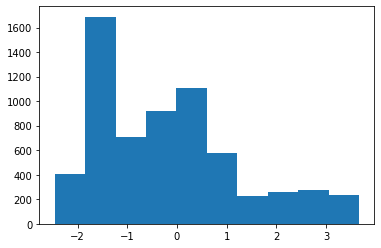

In [0]:
import matplotlib.pyplot as plt
plt.hist(train_logits[:,0])

**Use unlabeled data**

In [0]:
labeled_data = data.sample(n=8000, random_state=42);     
train_texts, test_texts = train_test_split(labeled_data['text'],test_size=0.2,random_state=42)

all_ulabeled_data = data.drop(labeled_data.index)['text']
unlabeled_texts=all_ulabeled_data.sample(n=6400, random_state=42)


In [0]:
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in labeled_data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor_bin = torch.tensor(bin_emotions.tolist())

target_tensor=torch.max(target_tensor_bin,1)[1]
train_y_tensor, test_y_tensor  = train_test_split(target_tensor,test_size=0.2,random_state=42)


In [0]:
unlabeled_tokenized = unlabeled_texts.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [0]:
max_len = 0
for i in unlabeled_tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

unlabeled_padded = np.array([i + [0]*(max_len-len(i)) for i in unlabeled_tokenized.values])

In [0]:
unlabeled_attention_mask = np.where(unlabeled_padded != 0, 1, 0)
unlabeled_attention_mask.shape

(6400, 75)

In [0]:
unlabeled_input_ids = torch.tensor(unlabeled_padded)  
unlabeled_attention_mask = torch.tensor(unlabeled_attention_mask)

In [0]:
unlabeled_tokens_tensor = torch.tensor(unlabeled_input_ids)
unlabeled_masks_tensor = torch.tensor(unlabeled_attention_mask)

In [0]:
BATCH_SIZE=64
unlabeled_dataset = TensorDataset(unlabeled_tokens_tensor, unlabeled_masks_tensor)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE)

In [0]:
bert_clf.eval()
unlabeled_logits = []
#unlabeled_bert_predicted = []
with torch.no_grad():
    for step_num, batch_data in enumerate(unlabeled_dataloader):

        token_ids, masks = tuple(t for t in batch_data)

        logits = bert_clf(token_ids, masks)
        
        unlabeled_logits += list(logits)

        clear_output(wait=True)
        print("{0}/{1}".format(step_num, len(unlabeled_data) / BATCH_SIZE))

        #unlabeled_bert_predicted += list(torch.max(logits,1)[1])

In [0]:
unlabeled_logits_numpy= (i.numpy() for i in unlabeled_logits)
unlabeled_logits = np.vstack(unlabeled_logits_numpy)

In [0]:
unlabeled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(unlabeled_texts, unlabeled_logits)

In [0]:
unlabeled_predicted_logits = unlabeled_model.predict(test_texts)

In [0]:
unlabeled_bert_predicted=torch.max(torch.tensor(unlabeled_predicted_logits),1)[1]

In [0]:
print(classification_report(test_y_tensor,unlabeled_bert_predicted))

              precision    recall  f1-score   support

           0       0.90      0.50      0.64       229
           1       0.69      0.67      0.68       175
           2       0.73      0.92      0.81       517
           3       0.71      0.16      0.25       129
           4       0.74      0.94      0.83       485
           5       1.00      0.08      0.14        65

    accuracy                           0.74      1600
   macro avg       0.80      0.54      0.56      1600
weighted avg       0.76      0.74      0.71      1600

